In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys

In [2]:
start_day_to_analyze = '2020-05-15'
end_day_to_analyze = '2020-05-16'

In [3]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [4]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
session = requests.session()

In [5]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [6]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
ORDER BY algo_run_id
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [7]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price
0,3169,572,EAT,buy,189,20.14,"{'avg': 19.5275, 'rsi': 66.79951436012472, 'ma...",2020-05-15 14:32:28.948023+00:00,2020-05-15 14:32:29.086158,19.65,21.66
1,3170,572,EAT,sell,189,20.13,"{'avg': 19.5493, 'rsi': [53.23112982421667, 59...",2020-05-15 14:36:53.383130+00:00,2020-05-15 14:36:53.652552,19.65,21.66
2,3167,572,MRNS,buy,945,2.31,"{'avg': 2.2195, 'rsi': 68.42812872180352, 'mac...",2020-05-15 14:18:20.498658+00:00,2020-05-15 14:18:20.648585,2.21,2.61
3,3168,572,MRNS,sell,945,2.30,"{'avg': 2.235, 'rsi': [57.09123493462867, 62.1...",2020-05-15 14:23:31.433978+00:00,2020-05-15 14:23:31.683502,2.21,2.61


In [8]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))

In [9]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}

for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            revnue += delta

        revenues[run_id].append(revnue)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [10]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
1,572,momentum_long,PAPER,v0.1-381-g81e66ae,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-05-15 14:08:30.600234,2020-05-15 20:10:00.908300,market close


,symbol,count,revenue
1,MRNS,2,-9.45
0,EAT,2,-1.89


TOTAL REVENUE: -11.34 $


In [11]:

minute_history = {}
minute_history1 = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    for symbol, count in symbols.items():
        if symbol not in minute_history:
            minute_history[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = str((datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=10)).date()),
                to=str((datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date())).df
        

In [12]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.02 <= float(item - prev) / prev <= 0.02:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    print(now)
    #print(minute_history)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    #print(f'index:{minute_history_index} data:{minute_history["close"][minute_history_index]}')
    print(minute_history["close"][minute_history_index-10:minute_history_index])
    for back_track_min in range(120, len(minute_history.index), 60):
        #print("start")
        series = (
            minute_history["close"][-back_track_min:minute_history_index].dropna().between_time("9:30", "16:00").resample("5min").max()
        ).dropna()
        #print(series[-10:])
        # tlog(f"{symbol} find_resistances(): {len(series)}")

        diff = np.diff(series.values)
        #print(diff)
        high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
        #print(high_index)
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] >= current_value]
            )
            #print(f"local_maximas={local_maximas}")
            if len(local_maximas) > 0:
                return local_maximas
            continue
            
            clusters = dict(enumerate(grouper(local_maximas), 1))
            #print(f"cluster={clusters}")
            resistances = []
            for key, cluster in clusters.items():
                if len(cluster) > 1:
                    resistances.append(round(sum(cluster) / len(cluster), 2))
            resistances = sorted(resistances)

            if len(resistances) > 0:
                return resistances


    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    for back_track_min in range(120, len(minute_history.index), 60):
        series = (minute_history["close"][-back_track_min:minute_history_index].resample("5min").min()).dropna()
        diff = np.diff(series.values)
        high_index = np.where((diff[:-1] <= 0) & (diff[1:] > 0))[0] + 1
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] <= current_value]
            )
            if len(local_maximas) > 0:
                return local_maximas
            
    return None

2020-05-15 10:32:29.086158
timestamp
2020-05-15 10:22:00-04:00    19.895
2020-05-15 10:23:00-04:00    19.910
2020-05-15 10:24:00-04:00    19.875
2020-05-15 10:25:00-04:00    19.920
2020-05-15 10:26:00-04:00    20.065
2020-05-15 10:27:00-04:00    20.070
2020-05-15 10:28:00-04:00    20.090
2020-05-15 10:29:00-04:00    20.120
2020-05-15 10:30:00-04:00    20.120
2020-05-15 10:31:00-04:00    20.155
Name: close, dtype: float64
EAT analysis for run 572 with profit -1.89


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3806.46,-3806.46,buy,2020-05-15 14:32:29.086158,20.14,[19.67],"[20.15, 20.78]",189,"{'avg': 19.5275, 'rsi': 66.79951436012472, 'macd': [0.1039244245470492, 0.11016185288918834, 0.11379332121548913, 0.11813372151426904, 0.12058692720118103], 'vwap': 20.16, 'supports': [18.55, 18.63, 18.78, 19.46, 19.67], 'sell_macd': [0.05876496858768121, 0.06290760895020853, 0.06531865846710616, 0.06816728590278132, 0.06976144642534621], 'slow macd': [0.14132243911312514, 0.1428561595379172, 0.14403875292428125, 0.14545618290042484, 0.14660759499298592], 'macd_signal': [0.09447653350783769, 0.09761359738410783, 0.10084954215038408, 0.10430637802316108, 0.10756248785876507], 'resistances': [20.75, 20.78], 'position_ratio': '1.2', 'sell_macd_signal': [0.0519891672692087, 0.05417285560540867, 0.05640201617774816, 0.05875507012275479, 0.060956345383273075]}",21.66,19.65
1,-1.89,3804.57,sell,2020-05-15 14:36:53.652552,20.13,None,None,189,"{'avg': 19.5493, 'rsi': [53.23112982421667, 59.865030447939425], 'vwap': 20.15, 'reasons': 'bail', 'movement': 0.0004965243296920561, 'sell_macd': [0.07131988798378686, 0.07508399495621276, 0.07169129915607542, 0.061882818024070474, 0.060708900024792456], 'sell_macd_signal': [0.061268033694961206, 0.06403122594721151, 0.0655632405889843, 0.06482715607600154, 0.06400350486575972]}",21.66,19.65


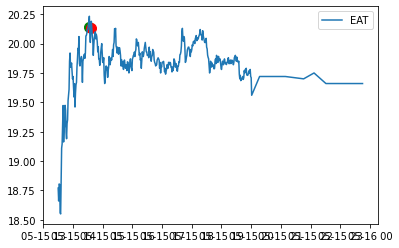

2020-05-15 10:18:20.648585
timestamp
2020-05-15 10:08:00-04:00    2.2201
2020-05-15 10:09:00-04:00    2.2300
2020-05-15 10:10:00-04:00    2.2500
2020-05-15 10:11:00-04:00    2.2698
2020-05-15 10:12:00-04:00    2.3000
2020-05-15 10:13:00-04:00    2.2863
2020-05-15 10:14:00-04:00    2.3000
2020-05-15 10:15:00-04:00    2.3109
2020-05-15 10:16:00-04:00    2.3041
2020-05-15 10:17:00-04:00    2.3164
Name: close, dtype: float64
MRNS analysis for run 572 with profit -9.45


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2182.95,-2182.95,buy,2020-05-15 14:18:20.648585,2.31,"[2.1199, 2.12, 2.145, 2.2201]",[2.3999],945,"{'avg': 2.2195, 'rsi': 68.42812872180352, 'macd': [0.023035805052353364, 0.02456785296122721, 0.026357715534148785, 0.026917206546732686, 0.02751946068426392], 'vwap': 2.31, 'supports': [2.07, 2.08, 2.09, 2.11, 2.145, 2.2281], 'sell_macd': [0.013324484146999716, 0.014310138916853177, 0.015458569400935485, 0.015799442902805882, 0.01616636455487619], 'slow macd': [0.022376273094579346, 0.022981278079786005, 0.023675476943697316, 0.024167539989712772, 0.02467596338392397], 'macd_signal': [0.022240227818130523, 0.02270575284674986, 0.023436145384229647, 0.024132357616730254, 0.024809778230236987], 'resistances': [2.39], 'position_ratio': '0.98', 'sell_macd_signal': [0.012881457538884093, 0.01316719381447791, 0.013625468931769424, 0.014060263725976716, 0.014481483891756611]}",2.61,2.21
1,-9.45,2173.50,sell,2020-05-15 14:23:31.683502,2.30,None,None,945,"{'avg': 2.235, 'rsi': [57.09123493462867, 62.10820811425663], 'vwap': 2.314, 'reasons': 'bail', 'movement': 0.004329004329004236, 'sell_macd': [0.016402890868119968, 0.017196592644346698, 0.015877443474596742, 0.014451126673822756, 0.014383202846286913], 'sell_macd_signal': [0.015147698440369738, 0.01555747728116513, 0.015621470519851452, 0.015387401750645712, 0.015186561969773953]}",2.61,2.21


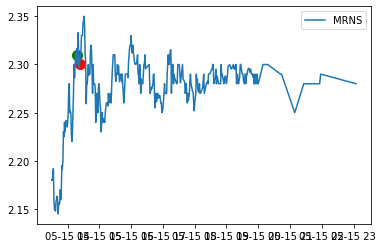

In [13]:
for run_id, count in runs.items():
    for symbol in minute_history:    
        if symbol not in trade_details[run_id]:
            continue
        start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d") + timedelta(hours=9, minutes=30)
        minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
        plt.plot(minute_history[symbol]["close"][minute_history_index:], label=symbol)

        delta = 0
        profit = 0
        
        operations = []
        deltas = []
        profits = []
        times = []
        prices = []
        qtys = []
        indicators = []
        target_price = []
        stop_price = []
        resistances = []
        supports = []
        for trade in trade_details[run_id][symbol]:
            resistance = None
            support = None
            if trade[0] == 'buy':
                resistance = find_resistance(trade[2], minute_history[symbol], trade[1])
                support = find_support(trade[2], minute_history[symbol], trade[1])
                
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            profit += delta
            plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' or trade[0] == 'sell_short' else 'r', s=100)
            deltas.append(round(delta, 2))
            profits.append(round(profit, 2))
            operations.append(trade[0])
            times.append(pd.to_datetime(trade[1]))
            prices.append(trade[2])
            qtys.append(trade[3])
            indicators.append(trade[4])
            target_price.append(trade[6])
            stop_price.append(trade[5])    
            resistances.append(resistance)
            supports.append(support)
        d = {
            'profit': profits,
            'trade': deltas,
            'operation': operations,
            'at': times,
            'price': prices,
            'support': supports,
            'resistance': resistances,
            'qty': qtys,
            'indicators': indicators,
            'target price': target_price,
            'stop price': stop_price
        }   
        print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
        display(HTML(pd.DataFrame(data=d).to_html()))
        plt.legend()
        plt.show()

In [ ]:
 pd.Timestamp('2020-04-16 13:44:06.066') 

In [ ]:
index = minute_history['NURO'].index.get_loc(pd.Timestamp('2020-04-16 13:44:06.066') , method='nearest')

In [ ]:
minute_history['NURO'][:index]

In [ ]:
series = minute_history['NURO'][:2417]['close']

In [ ]:
MACD(series.dropna().between_time("9:30", "16:00"))